# Document Information
* Title: "Graduate Admission"
* Author: Akoua Orsot
* Date: Sep 2, 2022
* Version: 1.1

# Graduate Admission 
In the course of a career, there arise multiple learning and professional opportunities like a Master's degree which often present itself as a fairly competitive race to the best universities and colleges around the world. Still, there are certain traits distinguishing applicants in the eye of admission offices. So, this notebook will attempt to build a predictive algorithm to determine chances of admissions (scale 0 to 1) given a set of variables. In doing so, we will follow LIME (Local Interpretable Model-agnostic Explanations) principles making it accessible and user-friendly to most readers.


## Table of Contents
1. Environment set-up
    * Importing Libraries
    * Loading the data
2. Initial Diagnostics
    * Glimpse
    * Descriptive Statitics
    * Target Variable Analysis
    * Predictors Analysis
3. Data Processing
    * Drop & Rename
    * Missing Values
    * Outliers
    * Duplicate Observations
    * Correlation Matrix
4. Exploraty Data Analysis (EDA)
    * What is the distribution of our continuous predictors?
    * Is there a cluster of admitted (prob >= 0.75) and non-admitted by GRE & TOEFL Scores?
    * How does the Undergrad GPA affect Masters Program Admissions given research experience?
    * Would the undergrad's college/university strenghten application statements and recommendations?
5. Feature Engineering
    * Categorical Encoding
    * Variable Standardization
6. Machine Learning set-up
    * Train-test split
    * Cross-validation
7. Machine Learning - Simple Models
    * Logistic Regression
    * k-Nearest Neighbors
    * Decision Tree
    * Stochastic Gradient Descent
8. Machine Learning - Ensemble Methods
    * Random Forest
    * Stochastic Gradient Boosting
    * StackingClassifier
9. Training Model Evaluation
    * Other metrics
    * Recommendation
10. Test Data - Model Performance

# 1. Environment set-up

In [195]:
## Importing Libraries

#Set seed
import random
random.seed(666)

# Manipulating & Visualizing Data
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

# Statistical Methods
from scipy import stats

# Categorical Encoding
import category_encoders as ce

# Variable Scaling
from sklearn.preprocessing import StandardScaler

# Training/Testing Split
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import cross_validate

# Simple ML models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Ensemble Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

# Performance metrics
import sklearn.metrics as skm

In [196]:
## Loading the dataset
df = pd.read_csv(r"C:\Users\Graduate\Desktop\ds_proj_data\Admission_Predict_Ver1.1.csv")
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


The dataset contains several parameters which are considered important during the application for Masters Programs. The parameters included are :
* GRE Scores ( out of 340 )
* TOEFL Scores ( out of 120 )
* University Rating ( out of 5 )
* Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
* Undergraduate GPA ( out of 10 )
* Research Experience ( either 0 or 1 )
* Chance of Admit ( ranging from 0 to 1 )

# 2. Initial Diagnostics

In [197]:
## Glimpse of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [198]:
## Descriptive Statistics
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


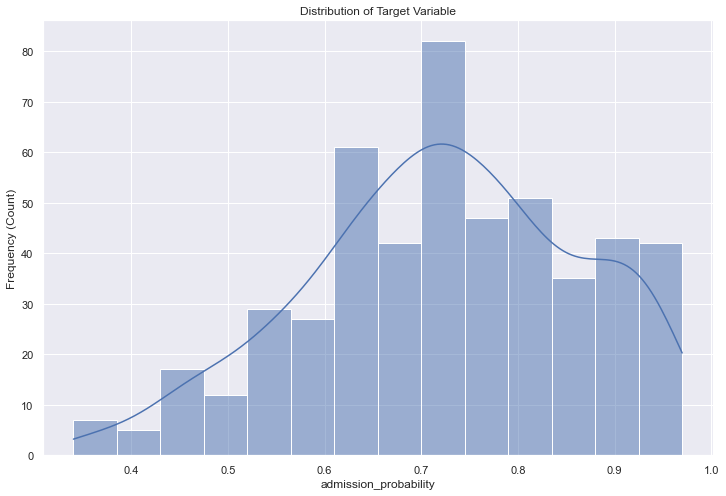

In [199]:
## Target Variable Analysis
sns.histplot(data=df, x='Chance of Admit ', kde=True)
plt.xlabel("admission_probability")
plt.ylabel("Frequency (Count)")
plt.title("Distribution of Target Variable")
plt.show()

**Takeaway:** We have here a left-skewed distribution of admission chances among the pool of candidates. With most people sitting in the range of 0.6 to 0.8, we can assume that those students demonstrated comopentency in the various test scores and undergraduate studies. 

# 3. Data Processing

**Note:** Before anything, we will proceed in dropping the Serial No. column and renaming some columns to retain ease of data manipulation.

In [200]:
## Drop & Rename 
def initial_processing(data, col_drop, col_rename):
    """ A simple functin to simnple processing: drop, rename, remove duplicate
    
    Parameters
    ----------
    data : dataframe
        A dataset
    col_drop : list
        A list of column names to drop
    col_rename : dict
        A dictionary pairing the old and new column names desired

    Returns
    -------
    data
        a modified dataframe
    """ 
    #Drop the 'Serial No.' column
    data.drop(col_drop, axis=1, inplace=True)

    # Renaming the target variable and one predictor
    data.rename(columns=col_rename, inplace=True)
    
    # Removing any Duplicate Observations if any
    data.drop_duplicates(keep='first', inplace=True)
    return data

In [201]:
## Drop & Rename 
df = initial_processing(df, col_drop = ['Serial No.'],
                 col_rename = {"Chance of Admit ": "admission_probability", 'LOR ': 'LOR'})
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,admission_probability
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [202]:
# Applying statistical imputation
def imputation_missing_val(data):
    """ Function to impute missing value using median and mode
    
    Parameters
    ----------
    data : dataframe
        A dataset

    Returns
    -------
    data
        an imputed dataframe
    """ 
    
    # Filter the columns with missing values
    null_cols = data.columns[data.isna().any()].tolist()
    
    for col in null_cols:
        # Impute using median for numeric columns
        if data[col].dtype.kind in 'iufc':
            data[col] = data[col].transform(lambda x: x.fillna(x.median()))
            
        # Impute using median for non-numeric columns
        else:
            data[col] = data[col].transform(lambda x: x.fillna(x.mode()))
    
    return data


In [203]:
# Identify missing values and dealing with them if present
def identify_missing_val(data):
    """ Function to identify missing/na values
    
    Parameters
    ----------
    data : dataframe
        A dataset

    Returns
    -------
    data
        a dataframe with no missing values 
        either after imputation or original format
    """
    
    # Count number of missing values 
    sum_nulls = data.isna().sum().sum()
    print("With %d null/na values in the dataset:" % sum_nulls)
    
    # Only visualize if missing values present
    if sum_nulls > 0: 
        print("- We need to resolve this issue.")
        plt.figure(figsize=(10,6))
        sns.heatmap(df.isna().transpose(),
                    cmap="YlGnBu",
                    cbar_kws={'label': 'Missing Data'})
        plt.xlabel("Features")
        plt.ylabel("Observations")
        plt.show()
        
        # Proceeding in imputing the dataset with missing values
        data = imputation_missing_val(data)
        sum_nulls = data.isna().sum().sum()
        print("After imputation, we have missing {:d} values in our data." % sum_nulls)
    else:
        print("- No action needed")
        pass
    return data

In [204]:
## Missing Values
df = identify_missing_val(df)
df.head()

With 0 null/na values in the dataset:
- No action needed


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,admission_probability
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


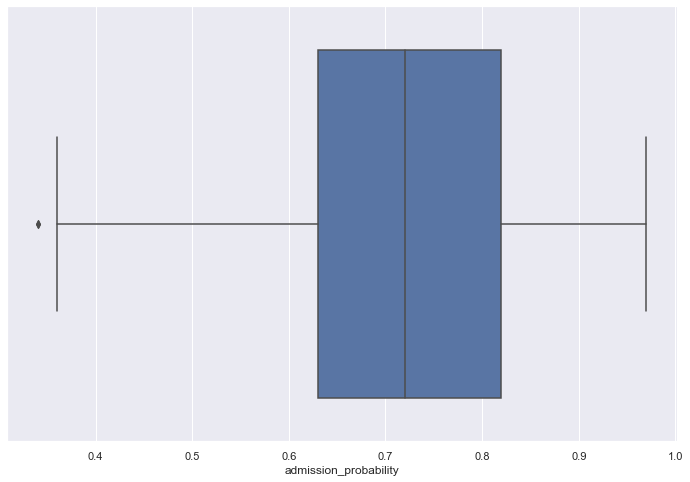

In [205]:
## Outliers
sns.boxplot(data=df, x='admission_probability')
plt.show()

In [206]:
# Z score 
z = np.abs(stats.zscore(df['admission_probability']))
 
# Position of the outlier
print(np.where(z > 2.5))
list(np.where(z > 2.5)[0])

(array([ 58,  92,  94, 376], dtype=int64),)


[58, 92, 94, 376]

**Takeaway:** From a visual standpoint, the boxplot only shows one clear outlier on the lower end of the distribution. However, when conducting the z-score calculation at ±2.5 away from the σ, we detected 4 outliers.

**Note:** Now, we will proceed in doing the same thing with each continuous independent variable

In [207]:
# Detecting outliers using z-score
def outliers_detection(data, threshold=2.5):
    """ Function to detect outliers
    
    Parameters
    ----------
    data : dataframe
        A dataset
    threshold:
        The threshold at which a value is an outlier
        ±2.5σ from the µ

    Returns
    -------
    data
        a dataframe with no missing values 
        either after imputation or original format
    """
    for col in data.columns:
        # Calculating the z-score for each predictor
        var = data[col]
        z = np.abs(stats.zscore(var))

        # Outlier
        pos = list(np.where(z > threshold)[0])
        no_of_outliers = len(pos)
        if no_of_outliers > 0:
            outliers = list(var[pos])
            print("- The", col, "variable has", no_of_outliers, "outliers as follows:", outliers)

        else:
            print("- No outliers detected for the", col, "variable")
    
outliers_detection(df)

- No outliers detected for the GRE Score variable
- The TOEFL Score variable has 1 outliers as follows: [92]
- No outliers detected for the University Rating variable
- No outliers detected for the SOP variable
- The LOR variable has 1 outliers as follows: [1.0]
- The CGPA variable has 1 outliers as follows: [6.8]
- No outliers detected for the Research variable
- The admission_probability variable has 4 outliers as follows: [0.36, 0.34, 0.36, 0.34]


**Takeaway:** As we thought about handling those outliers, we decided to keep them all since ggood data science practices advocates to conserve as many data points as possible. Thus, allowing us to limit the biases simply to produce a better fitting model or statistically significant results.

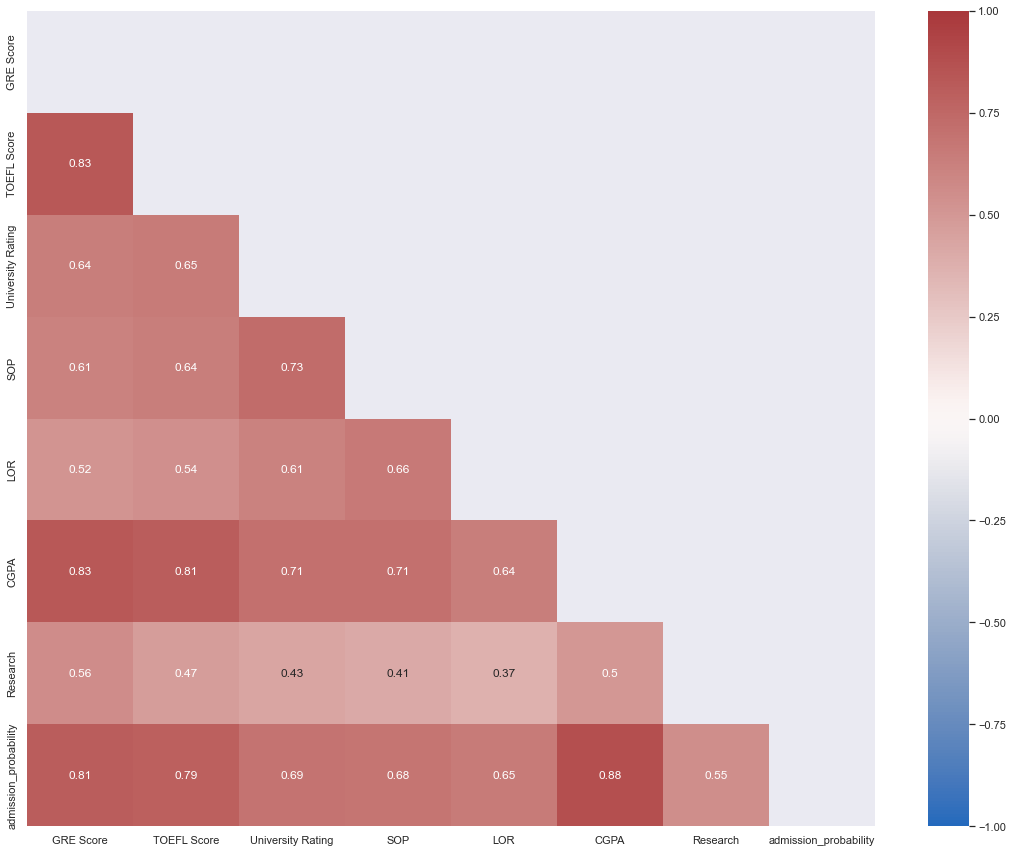

In [208]:
# Correlation Matrix
f = plt.figure(figsize=(19, 15))
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, 
            center=0, cmap='vlag', mask=mask)
plt.show()

**Takeaway:** From the correlation plot, we can determine a few correlated relationships between the independent variable as well as with respect to the target variable. For instnace, the GRE Score and TOEFL Scores are a high correlation coefficient of 0.83 while the CGPA and Adimission probabilty is 0.88

# 4. Inquiry Exploration

### What is the distribution of our continuous predictors?

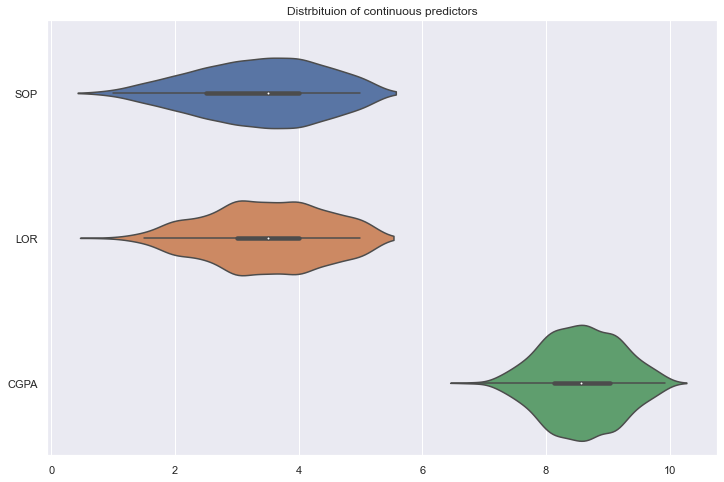

In [209]:
# Isolating the continous variables
cont_vars = ['SOP', 'LOR', 'CGPA']

# Plotting the violin plots
sns.violinplot(data=df[cont_vars], orient='h')
plt.title("Distrbituion of continuous predictors")
plt.show()

**Takeaway:** In the chart above, we can observe a fairly normal distrbution across all three variables thus, reassuring us of the normality withing our data,.

### Is there a cluster of admitted (prob >= 0.75) and non-admitted by GRE & TOEFL Scores?

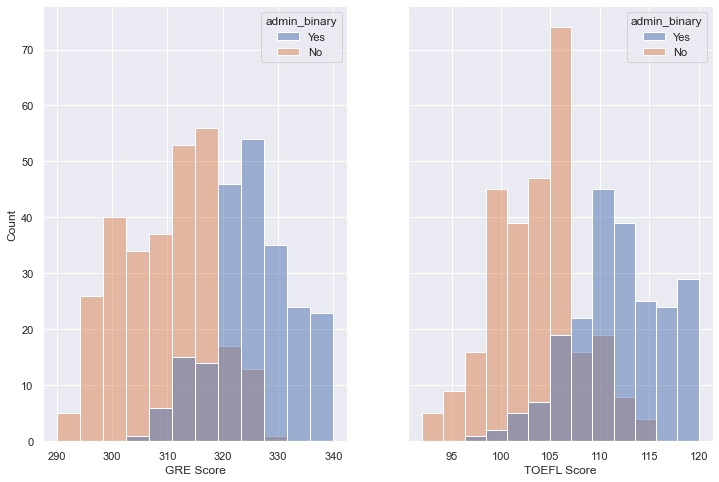

In [210]:
# Making a categorical target varibale using a threshold
df['admin_binary'] = np.where(df['admission_probability'] >= 0.75, 'Yes', 'No')

# Ploting the TOEFL & GRE Scores accordingly
fig = plt.figure()
gs = fig.add_gridspec(1, 2, hspace=0.2, wspace=0.2)
(ax1, ax2) = gs.subplots(sharex=False, sharey=True)
sns.histplot(ax=ax1, data=df, x = 'GRE Score', hue='admin_binary')
sns.histplot(ax=ax2, data=df, x = 'TOEFL Score', hue='admin_binary')
plt.show()

### How does the Undergrad GPA affect Masters Program Admissions given research experience?

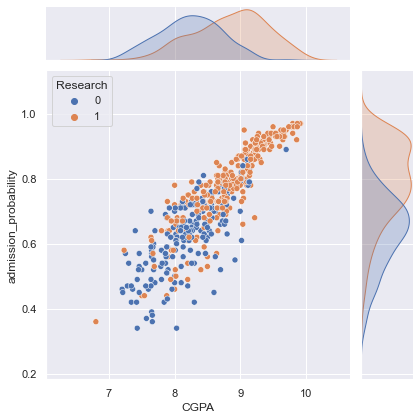

In [211]:
sns.jointplot(data=df, x='CGPA', y='admission_probability', hue='Research')
plt.show()

**Takeaway:** With the multiplot shown of admissiong probability with respect to College GPA, there appreaws to be a strong correlated relationship. Though they are not as clearly seperated, the clusters of those with higher results and research experience stands a better chance of admission compared to their counterparts with no research experince and average to low GPA.

### Would the undergrad's college/university strenghten application statements and recommendations?

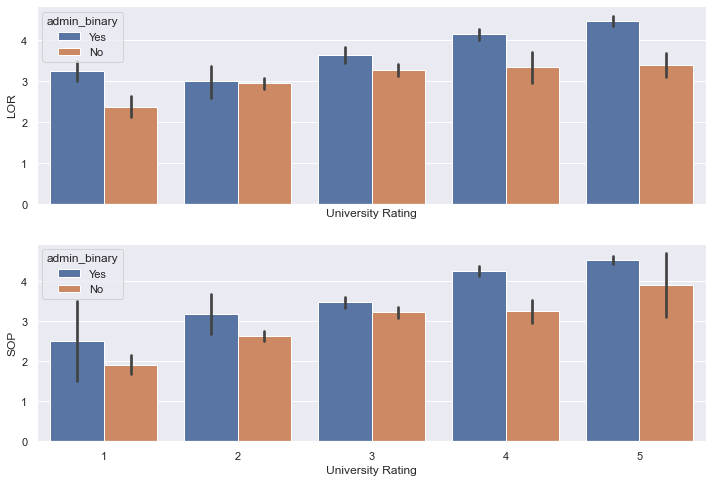

In [212]:
fig = plt.figure()
gs = fig.add_gridspec(2, 1, hspace=0.2, wspace=0.2)
(ax1), (ax2) = gs.subplots(sharex=True, sharey=False)
sns.barplot(ax=ax1, data=df, x='University Rating',  y='LOR', hue='admin_binary')
sns.barplot(ax=ax2, data=df, x='University Rating',  y='SOP', hue='admin_binary')
plt.show()

**Takeaway:** In contrast to the clear seperation above, the university rating does not have a drastic effect on those predictors. It would indicates how much weight this variable has in the final decision process. 

In [213]:
# Getting rid of the categorical transformation of the target variable
df.drop(['admin_binary'], inplace=True, axis=1)

# 6. Feature Engineering

**Note:** Based on the glimpse into the dataset, it appears that we have two categorical variables 
that are University Rating and Research being of type ordinal and binary respectively. 
In that vein, we will proceed in encoding them accordingly.

In [215]:
## Categorical Encoding
def categorical_encoding(data, cat_vars):
    """ Function encoding binary and nomial categorical variables
    
    Parameters
    ----------
    data : dataframe
        A dataset
    cat_vars:
        A dictionary of categorical variables that are binary, nominal and/or ordinal.

    Returns
    -------
    data
        a dataframe with all categorical encoding transfomation
    """
    # Creating a list with the ordinal variables and their mapping
    ord_cols, ord_col_map = [], []
    
    # Assign appropriate encoder for each categorical variable
    print("Enconding recursively the binary and nominal variables")
    for var, var_type in cat_vars.items():
        if var_type == 'binary':
            enc_bin = ce.BinaryEncoder(cols = [var], return_df = True)
            data = enc_bin.fit_transform(data) 
        
        elif var_type == 'nominal':
            enc_nom = ce.OneHotEncoder(cols = [var], use_cat_names=True, 
                                   return_df = True)
            data = enc_nom.fit_transform(data) 
            
        elif var_type == 'ordinal':
            ord_cols.append(var)
            var_map = sorted(data[var].unique())
            var_range = list(range(1, len(var_map)+1))
            ord_col_map.append({"col": var, "mapping": {var_map[i]: var_range[i] 
                                                        for i in range(len(var_map))}})
            data[var] = data[var].astype(object)
        else:
            print("Incorrect variable type")

    # Enconding all ordinal in bulk
    print("All ordinal variables are encoded together with the list of mapping dict")
    ord_enc = ce.OrdinalEncoder(cols=ord_cols,
                                mapping = ord_col_map, return_df = True)
    data = ord_enc.fit_transform(data)  
    
    return data


# Encoding all categorical variables
cat_vars = {'University Rating': 'ordinal','Research': 'binary',
           'SOP': 'ordinal', 'LOR': 'ordinal'}
df = categorical_encoding(df, cat_vars=cat_vars)
df.head()

Enconding recursively the binary and nominal variables
[{'col': 'University Rating', 'mapping': {1: 1, 2: 2, 3: 3, 4: 4, 5: 5}}, {'col': 'SOP', 'mapping': {1.0: 1, 1.5: 2, 2.0: 3, 2.5: 4, 3.0: 5, 3.5: 6, 4.0: 7, 4.5: 8, 5.0: 9}}, {'col': 'LOR', 'mapping': {1.0: 1, 1.5: 2, 2.0: 3, 2.5: 4, 3.0: 5, 3.5: 6, 4.0: 7, 4.5: 8, 5.0: 9}}]
All ordinal variables are encoded together with the list of mapping dict


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research_0,Research_1,admission_probability
0,337,118,4,8,8,9.65,0,1,0.92
1,324,107,4,7,8,8.87,0,1,0.76
2,316,104,3,5,6,8.00,0,1,0.72
3,322,110,3,6,4,8.67,0,1,0.80
4,314,103,2,3,5,8.21,1,0,0.65


**Note:** Given the differences in scales across the independent variables, we will proceed in standardizing them all with a preprocessing step in sklearn.

In [ ]:
def var_scaling(data): 
    """ Function standardizing numerical variable of different scales
    
    Parameters
    ----------
    data : dataframe
        A dataset
    Returns
    -------
    data
        a standardized dataframe
    """
    scaler = StandardScaler()
    for col in data.columns:
        if col in ['University Rating', 'Research', 
                   'admission_probability']:
            continue
        else:
            data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

df = var_scaling(df)
df.head()

# 5. Machine Learning set-up

Under this section, we will explain the procedure of two main splitting approach to estimate our models' performance. 

**Definition:** Often denoted as the most popular by its simplicity, the train-test split is a sampling technique dividing the dataset between training and testing sets. In doing so, the goal would be to have enough (but not too much) in our training set used for the machine learning model to predict the observations in the testing set as accurately as possible. Most would opt for a 70/30 training-testing split, respectively, others 80/20, 60/40, or whichever else works best for the case scenario. Further information [here](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). 

In [ ]:
# Splitting features & target variable
X = df.drop(['admission_probability'], axis=1).values
y = df['admission_probability'].values

# Training Testing Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

**Definition:** As the name would suggest, we will engage here in the process of validation to ensure reliability on our model. Cross-Validation is a statistical method applied in various ways to estimate the model's performance. Some examples are **Holdout Method, K-Fold, Stratified K-Fold, Leave-P-Out.**  Further information [here](https://machinelearningmastery.com/k-fold-cross-validation/) and [here](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f).

# 7. Machine Learning - Simple Models

This section will leverage the powerful sci-kit-learn package to build multiple models with little to no parameter tuning for comparison. We will only use the cross-validation error on our training dataset to avoid any data leakage.

In [ ]:
# Dictionary to store model structures
models = dict()

# Addigin the different models
models.update({'Multiple Linear Regression':LinearRegression()})
models.update({'k-Nearest Neighbors Regressor':KNeighborsRegressor(n_neighbors=2)})
models.update({'Decision Tree Regressor':DecisionTreeRegressor()})
models.update({'Support Vector Regressor':SVR()})

# Checking the dictionary of models
models

In [ ]:
# Cross-Validation & model building
for name, model in models.items():
    cv_results = cross_validate(model, X_train, y_train, 
                                cv=10, scoring='neg_root_mean_squared_error')
    n_scores = -1*cv_results['test_score']
    # report performance
    print('{} - RMSE: {:.5f} ({:.5f})' .format(name, np.mean(n_scores), np.std(n_scores)))
    #print('{} - {}' .format(name, n_scores))

**Takeaway:** Our best model is the Multiple linear regression with the lowest Cross-validated RMSE at 0.06003. The second best would be SVR instead of kNN because the lower standard deviation would indicate better reliability when thinking about scaling.

# 8. Machine Learning - Ensemble Methods

This section will extend our work in machine learning to incorporate ensemble methods. We generated simple models and compared the scores, which appear satisfactory, with the lowest cross validated RMSE at 0.06. In ourdesire greater performance and stability in our predictive algorithm, ensemble methods would prove more effective. Most often, they act as a 'superposer' of multiple models throughout various ways and thus, bolster their predictive power. Further Information [here](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/). 

In [ ]:
# Dictionary to store ensemble model structures
ensemble_models = dict()

# Adding Random Forest and SGB for regression
ensemble_models.update({'Random Forest Regressor':RandomForestRegressor()})
ensemble_models.update({'Stochastic Gradient Boosting Regressor':GradientBoostingRegressor()})

## StackingClassifier (with two best models)
stack_reg = StackingRegressor(estimators= [('svr', SVR())],
                               final_estimator=LinearRegression())
ensemble_models.update({'Stacking Regressor':stack_reg})

ensemble_models

In [ ]:
# Cross-Validation & model building
for name, model in ensemble_models.items():
    cv_results = cross_validate(model, X_train, y_train, 
                                cv=10, scoring='neg_root_mean_squared_error')
    n_scores = -1*cv_results['test_score']
    # report performance
    print('{} - RMSE: {:.5f} ({:.5f})' .format(name, np.mean(n_scores), 
                                               np.std(n_scores)))

**Takeaway:** Based on the results, Stochastic Gradient Descent performs better than the other two ensemble methods while offering worse results than the Multiple Linear Regression. We would consider preferably the simple model that is the Multiple Linear Regression based on Occam's razor principles regarding complexity (Further information [here](https://math.ucr.edu/home/baez/physics/General/occam.html)). However, a more robust approach would take into account other metrics before recomming a final model for implementation and deployment into a real-world setting.

# 10. Model Performance Evaluation

In [ ]:
# Define the metrics dictionary
metrics = {}

# Adding the desired metrics
metrics.update({'R-Squared':'r2'})
metrics.update({'MSE':'neg_mean_squared_error'})
metrics.update({'RMSE':'neg_mean_absolute_error'})
metrics.update({'MAE':'neg_root_mean_squared_error'})

metrics

In [ ]:
# Function to evaluate model with a panoply of metrics
def performance_metrics(model, X, y, cv, metrics):
    '''Compiling multiple model metrics
    '''
    scoring = tuple(metrics.values())
    names = list(metrics.keys())
    
    cv_results = cross_validate(model, X, y, cv=cv, 
                                scoring=scoring)
    scores = [i for i in cv_results.keys() if 'test' in i]
    
    metrics_dict = {'Metrics': [],
                    'CV_mean': [],
                    'CV_std': [] }
    
    for idx in range(0, len(scores)):
        score_values = abs(cv_results[scores[idx]])
        metrics_dict['Metrics'].append(names[idx])
        metrics_dict['CV_mean'].append(np.mean(score_values))
        metrics_dict['CV_std'].append(np.std(score_values))
    
    metrics_df = pd.DataFrame(metrics_dict, columns = ['Metrics', 'CV_mean', 'CV_std'])
    print(metrics_df, "\n")

In [ ]:
# Function Parameters
X, y = X_train, y_train
cv = 5
metrics = metrics

# Output
models = [LinearRegression(), GradientBoostingRegressor()]
for model in models:
    print("Performance metrics for", str(model))
    performance_metrics(model, X, y, cv, metrics)

In [ ]:
## Random Search

# define search space
linreg_space = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
            }
sdg_space = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
            }